In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np


dataset = load_dataset('ag_news')

def simple_tokenizer(text):
    return text.lower().replace("'", "").split()

from collections import Counter
counter = Counter()
for ex in dataset['train']:
    counter.update(simple_tokenizer(ex['text']))

vocab_size = 20000
most_common = [t for t,_ in counter.most_common(vocab_size - 2)]
vocab = {t:i+2 for i,t in enumerate(most_common)}
vocab['<pad>'] = 0; vocab['<unk>'] = 1

def encode(text):
    return [vocab.get(w,1) for w in simple_tokenizer(text)]

class NewsDataset(Dataset):
    def __init__(self, split): self.data = dataset[split]
    def __len__(self): return len(self.data)
    def __getitem__(self, i):
        txt = torch.tensor(encode(self.data[i]['text']),dtype=torch.long)
        lbl = self.data[i]['label']
        return txt, lbl

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    xs, ys = zip(*batch)
    lengths = [x.size(0) for x in xs]
    xs = pad_sequence(xs, batch_first=True, padding_value=0)
    return xs, torch.tensor(ys), lengths

loader = DataLoader(NewsDataset('train'), batch_size=64, shuffle=True, collate_fn=collate_fn)


train_size = int(0.9 * len(loader.dataset))
val_size = len(loader.dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(loader.dataset, [train_size, val_size])
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=64, collate_fn=collate_fn)

In [42]:

class TransformerModelWithAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_heads=4, num_layers=3,
                 hidden_dim=256, num_classes=4, max_len=500, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_len, embed_dim))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=num_heads,
            dim_feedforward=hidden_dim, dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_dim, num_classes)
        self.num_layers = num_layers
        self.attention_weights = []

    def forward(self, x):
        B, S = x.size()
        # Embedding + positional
        emb = self.embedding(x) + self.positional_encoding[:, :S, :]
        # Пропускаем через каждый слой вручную чтобы сохранить веса внимания
        out = emb
        self.attention_weights = []
        for layer in self.transformer_encoder.layers:
            # Self-attention
            attn_out, attn_w = layer.self_attn(out, out, out, need_weights=True)
            # Feedforward + residual
            ff = layer.linear2(layer.dropout(layer.activation(layer.linear1(attn_out))))
            out = layer.norm2(ff + layer.dropout(attn_out))
            out = layer.norm1(out + layer.dropout(out)) if False else out  # нормализация реализуется внутри encoder
            self.attention_weights.append(attn_w.detach().cpu())
        # Global pooling and classifier
        pooled = out.mean(dim=1)
        logits = self.fc_out(pooled)
        return logits


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerModelWithAttention(len(vocab), num_heads=4, num_layers=5, max_len=300).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

losses, accuracies = [], []

def evaluate(model, loader):
    model.eval(); correct=0; total=0
    with torch.no_grad():
        for x,y,_ in loader:
            x,y = x.to(device), y.to(device)
            logits = model(x)
            preds = logits.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    return correct/total

epochs = 10
for ep in range(epochs):
    model.train(); total_loss=0
    for x,y,_ in train_loader:
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    val_acc = evaluate(model, val_loader)
    losses.append(avg_loss)
    accuracies.append(val_acc)
    print(f"Epoch {ep+1}/{epochs}, Loss: {avg_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/10, Loss: 0.5558, Val Acc: 0.8828
Epoch 2/10, Loss: 0.3023, Val Acc: 0.8986
Epoch 3/10, Loss: 0.2392, Val Acc: 0.8977
Epoch 4/10, Loss: 0.2014, Val Acc: 0.9050
Epoch 5/10, Loss: 0.1726, Val Acc: 0.9125
Epoch 6/10, Loss: 0.1507, Val Acc: 0.9107
Epoch 7/10, Loss: 0.1306, Val Acc: 0.9110
Epoch 8/10, Loss: 0.1167, Val Acc: 0.9084
Epoch 9/10, Loss: 0.1056, Val Acc: 0.9093
Epoch 10/10, Loss: 0.0938, Val Acc: 0.9076


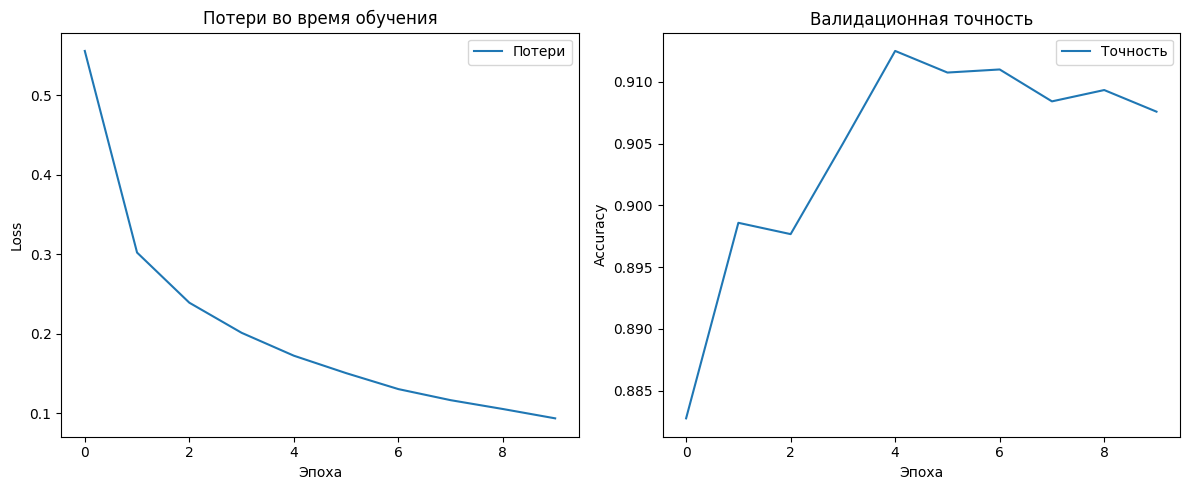

In [43]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(losses, label='Потери')
plt.title('Потери во время обучения')
plt.xlabel('Эпоха'); plt.ylabel('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(accuracies, label='Точность')
plt.title('Валидационная точность')
plt.xlabel('Эпоха'); plt.ylabel('Accuracy'); plt.legend()
plt.tight_layout(); plt.show()

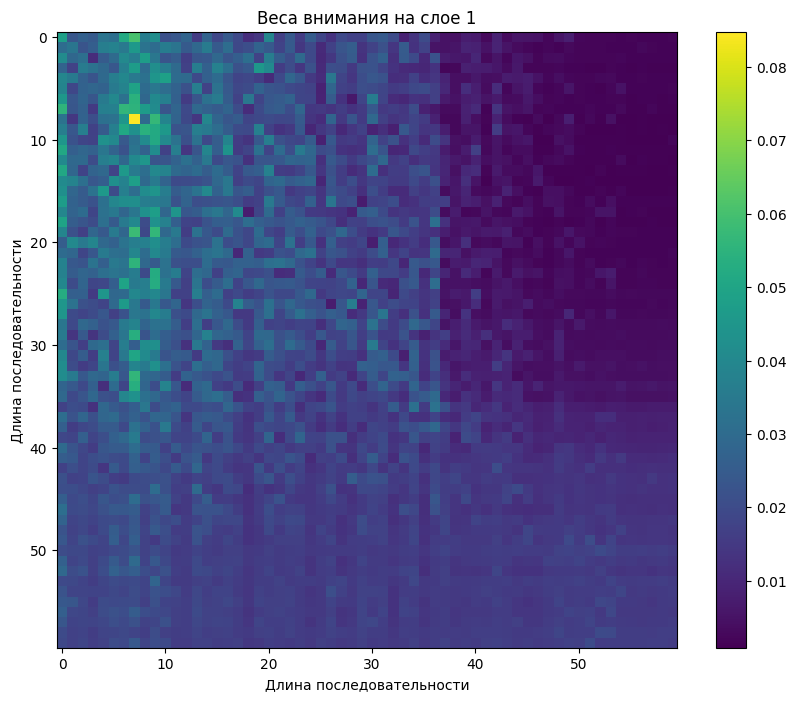

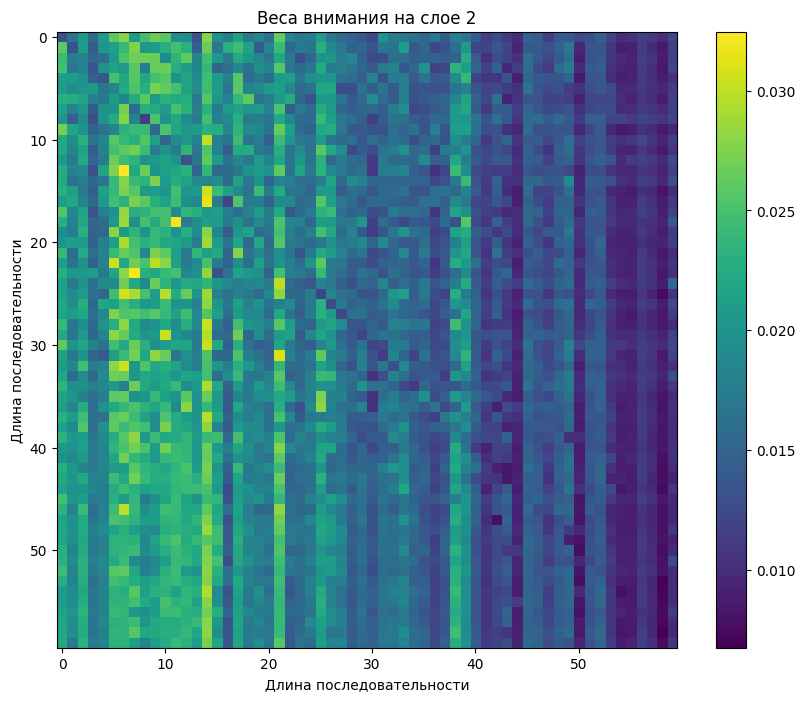

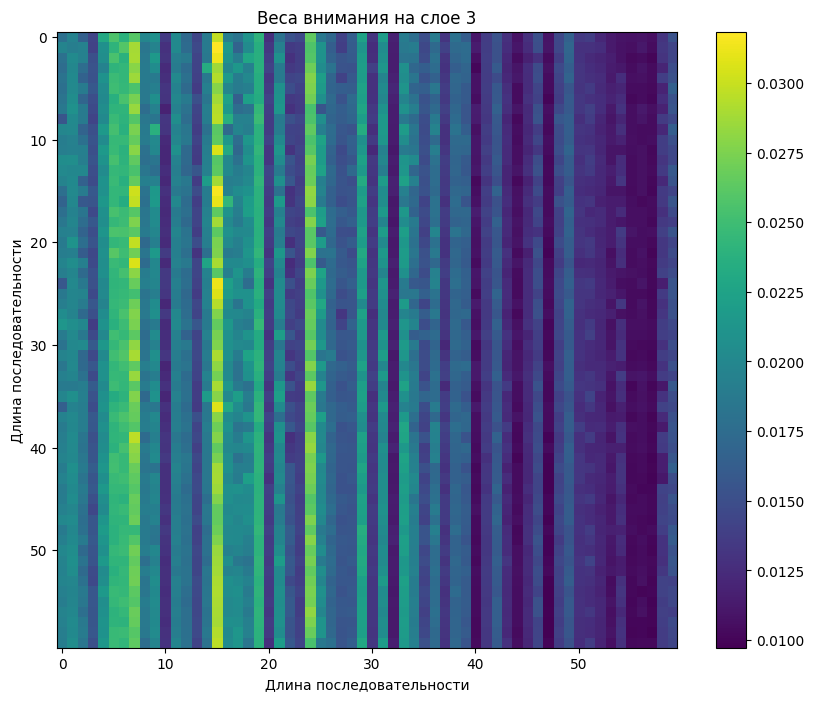

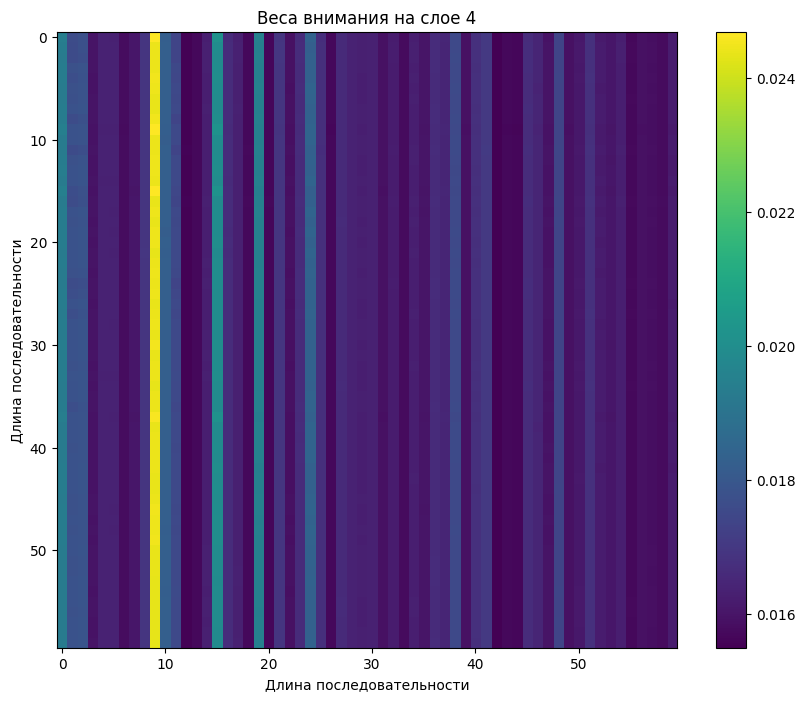

In [49]:
# Выберем первый батч и пропустим через модель, чтобы заполнить attention_weights
x,y,_ = next(iter(val_loader))
x = x.to(device)
_ = model(x)
# Для первых 4 слоев
for layer in range(min(4, len(model.attention_weights))):
    w = model.attention_weights[layer]  # shape (B, S, S)
    attention_weights = w
    # Если веса внимания имеют больше чем 2 размерности, усредняем по батчу
    if len(attention_weights.shape) > 2:
        attention_weights = attention_weights.mean(dim=0).squeeze().detach().numpy() # Усреднение по батчу
    
    # Проверяем размерность после усреднения
    if attention_weights.ndim == 1:
        attention_weights = attention_weights[None, :] # Преобразование в двумерный массив (1, seq_len)
    
    plt.figure(figsize = (10, 8))
    plt.imshow(attention_weights, cmap = 'viridis', aspect = 'auto')
    plt.colorbar()
    plt.title(f"Веса внимания на слое {layer + 1}")
    plt.xlabel("Длина последовательности")
    plt.ylabel("Длина последовательности")
    plt.show()


## Выводы

Модель довольно хрошо обучилась на решение задачи (acc = 0.9)

По весам внимания видим, что на ранних слоях модель фокусируется на локальных зависимостях (большые веса при x ~ y), и чем ближе слой к концу тем более глобальные зависимости он улавливает (все больше похоже на вертикальные полосы)